# Autoencoders: Image Noise Reduction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2024-05-14 21:57:33.013071: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 21:57:33.013279: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 21:57:33.015842: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 21:57:33.046332: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 21:57:33.588264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)


(60000, 28, 28, 1)


In [4]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)


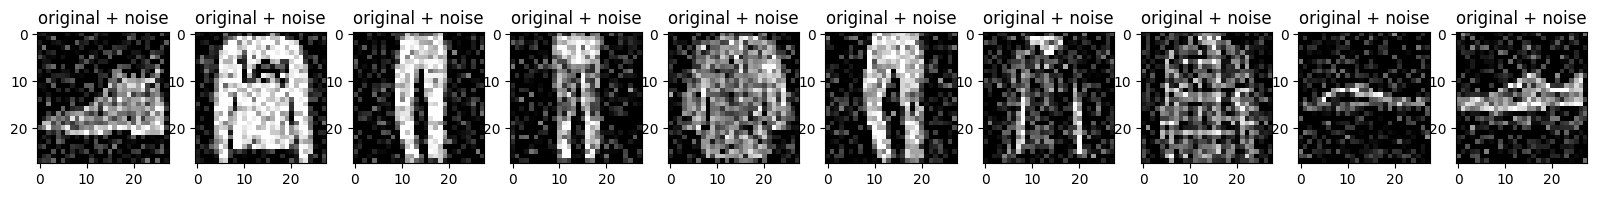

In [5]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [6]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [8]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0355 - val_loss: 0.0113
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0106 - val_loss: 0.0096
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0079 - val_loss: 0.0079


In [9]:
autoencoder.save_weights('noise_reduction_model.weights.h5')

In [10]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 8)        │         1,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (32, 14, 14, 8)        │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (32, 28, 28, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 28, 28, 1)        │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

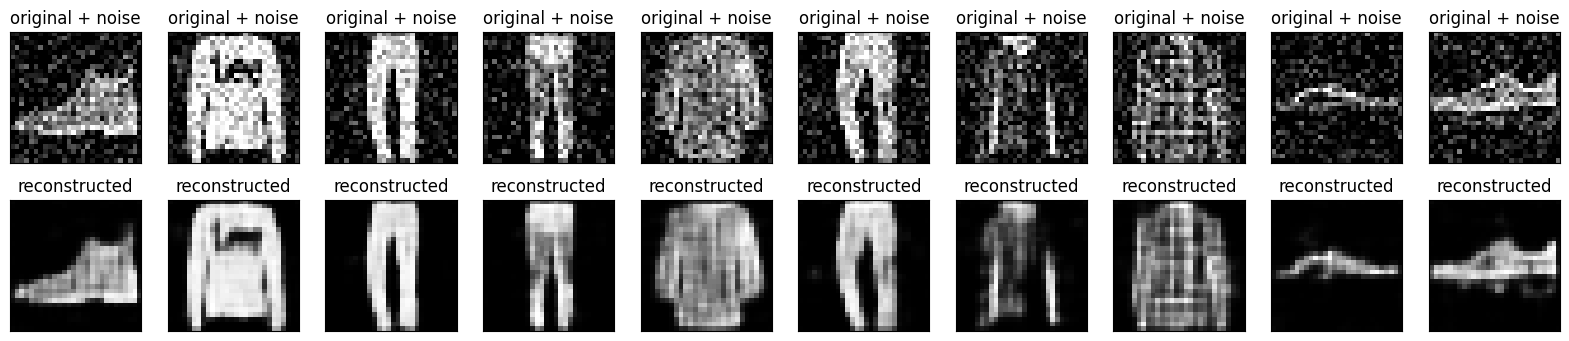

In [11]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()
